# Figure 5A

Notebook to generate figure 5

- A) Average pCO2misfit in the MPI and CNRM model for all years, December,January, and February (DJF)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib 
#import modin.pandas as pdm
import os
import glob
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import skill_metrics as sm


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot
from plotting_tools.taylor_diagram import TaylorDiagram
from plotting_tools.target_diagram import TargetDiagram
from stats_tools.target_diagram import target_axes
import cmocean.cm as cm

In [7]:
import cartopy.crs as ccrs

In [2]:
#dir_raw = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/raw'
#dir_clean = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/clean'
dir_figs = '/home/gloege/projects/ldeo_hpd/reports/figures'
dir_tests = '/local/data/artemis/workspace/gloege/data/test_sets'
dir_model = '/local/data/artemis/workspace/gloege/LDEO-FFN/data/HPD_output/XGB'
dir_prods = '/local/data/artemis/workspace/gloege/data/pCO2_producs/clean'

# Load data

## load test set

In [3]:
# load test data
ds_glodap = xr.open_dataset(f'{dir_tests}/GLODAP_1x1_198201-201812.nc')
ds_carioca = xr.open_dataset(f'{dir_tests}/CARIOCA_1x1_198201-201812.nc')
ds_soccom = xr.open_dataset(f'{dir_tests}/SOCCOM_1x1_198201-201812.nc')
ds_ldeo = xr.open_dataset(f'{dir_tests}/LDEO_1x1_198201-201812.nc')


# load HPD product

In [4]:
# Load data and average over models
ds_mod = xr.open_mfdataset(f'{dir_model}/*1982*.nc', 
                           combine='nested', 
                           concat_dim='models').mean('models')
ds_mod = ds_mod.transpose('time', 'lat', 'lon')

## Load products

In [6]:
ds_JMA_MLR = xr.open_dataset(f'{dir_prods}/JMA-MLR_1x1_199001-201712.nc')
ds_CSIR_ML6 = xr.open_dataset(f'{dir_prods}/CSIR-ML6_1x1_198201-201612.nc')
ds_NIES_NN = xr.open_dataset(f'{dir_prods}/NIES-NN_1x1_199001-201712.nc')
ds_SOM_FFN = xr.open_dataset(f'{dir_prods}/SOM-FFN_1x1_198201-201512.nc')
ds_FFNN_LSCE = xr.open_dataset(f'{dir_prods}/FFNN-LSCE_1x1_198501-201812.nc')

# time series 
dir_data = '/local/data/artemis/workspace/gloege'
# BATS
ds_bats = xr.open_dataset(f'{dir_data}/data/BATS/BATS.nc')

# HOT
ds_hot = xr.open_dataset(f'{dir_data}/data/HOT/HOT.nc')
ds_hot = ds_hot.where(ds_hot['spco2']>0)

# locations
BATS={'lat':31.83,
      'lon':360-(64.17)}

HOTS={'lat':22.75,
      'lon':360-158}


ds_hot_mon = ds_hot.resample(time='1M').mean()

ds_hot_mon = ds_hot_mon.assign_coords(lon=(202.5),
                                      lat=(22.5)).expand_dims(['lat','lon'])
ds_hot_mon = ds_hot_mon.transpose('time','lat','lon')

### ================================================
### force time vector to be proper format and range
### ================================================
dates = pd.date_range(start='1988-10-01T00:00:00.000000000', 
                      end='2017-12-01T00:00:00.000000000',
                      freq='MS')+ np.timedelta64(14, 'D')
da_dates = xr.DataArray(dates, dims='time')
ds_hot_mon['time'] = dates
ds_hot_mon = ds_hot_mon.squeeze()

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Plot locations of test data

In [8]:
# map locations
out_glod = (ds_glodap['spco2_mean'].mean('time')>0).where(ds_glodap['spco2_mean'].mean('time')>0)
out_ldeo = (ds_ldeo['spco2_mean'].mean('time')>0).where(ds_ldeo['spco2_mean'].mean('time')>0) 
out_soccom = (ds_soccom['out_mean'].mean('time')>0).where(ds_soccom['out_mean'].mean('time')>0) 
out_carioca = (ds_carioca['fCO2water_SST_wetatm_mean'].mean('time')>0).where(ds_carioca['fCO2water_SST_wetatm_mean'].mean('time')>0) 

<Figure size 3120x2145 with 0 Axes>

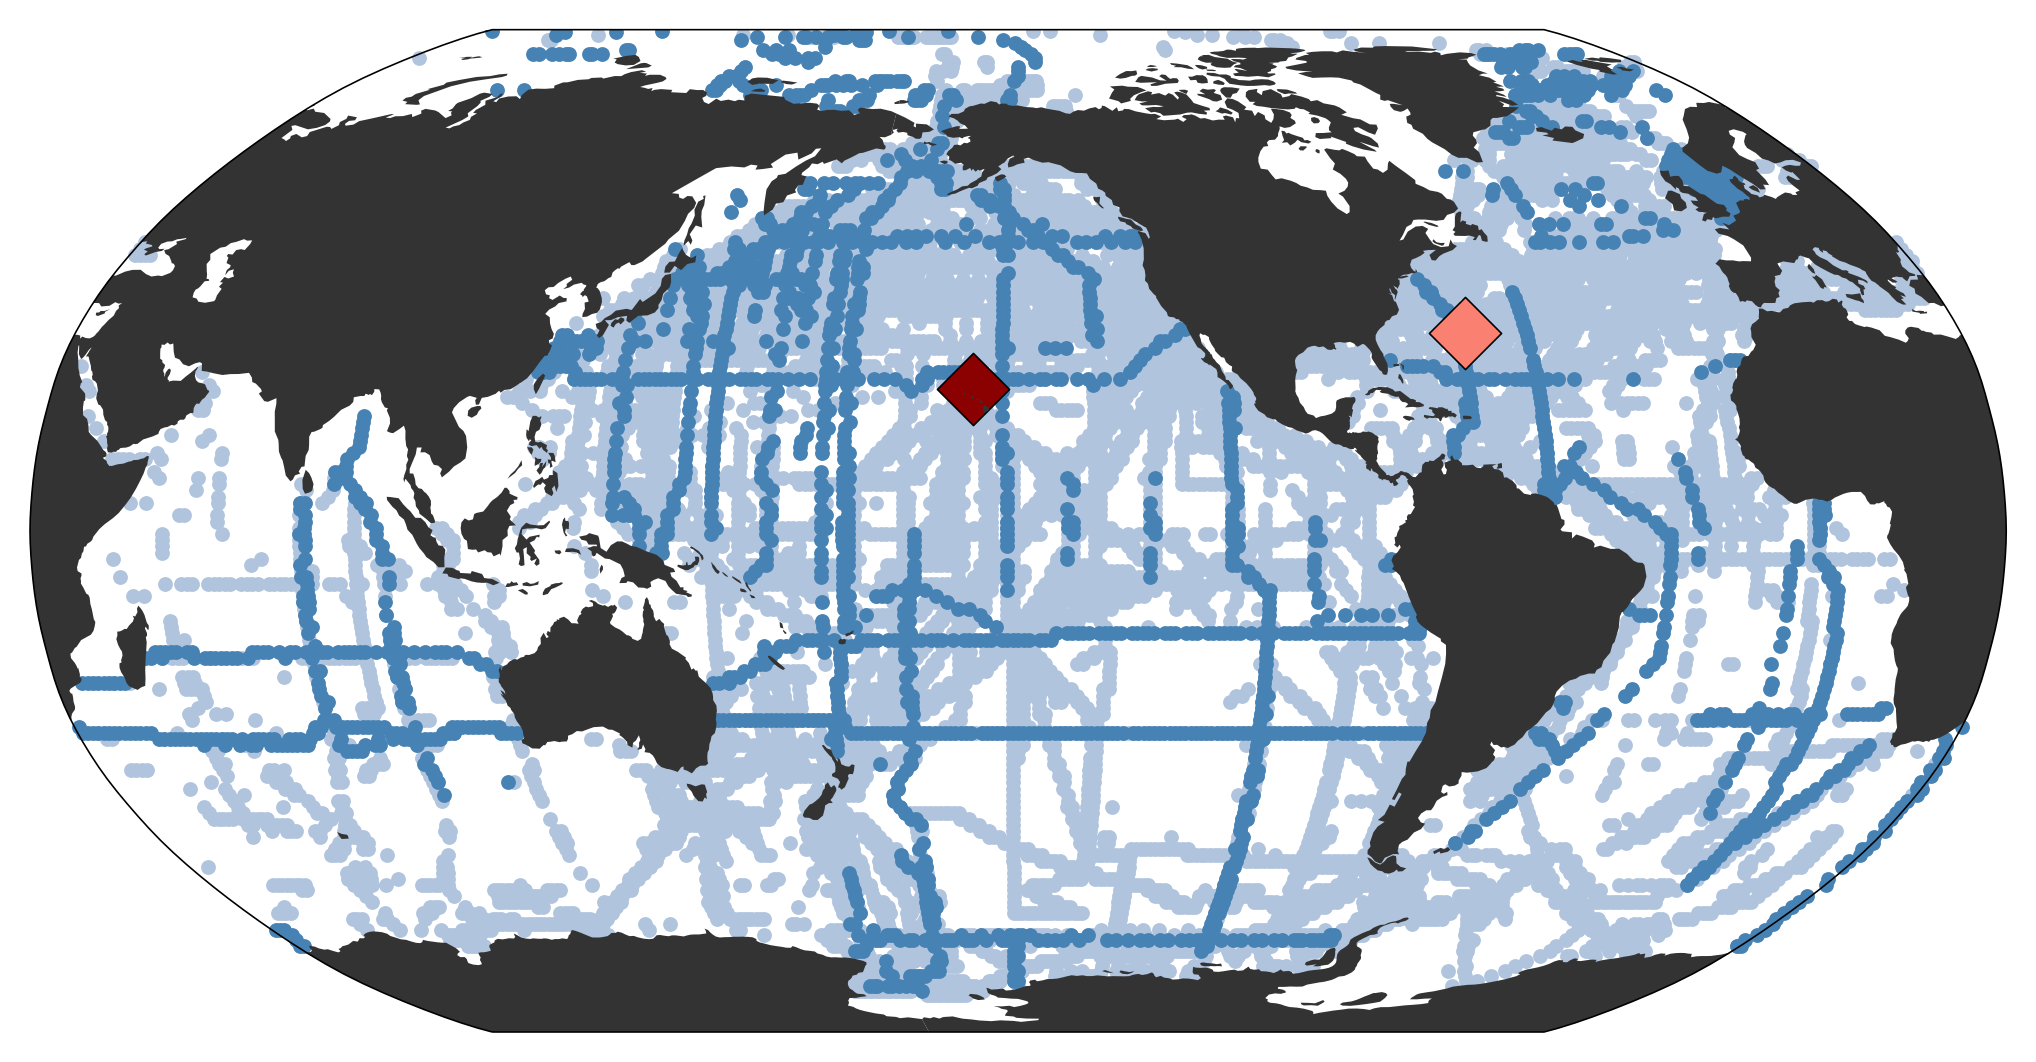

In [9]:
#a,b = np.meshgrid(out_glod['lon'], out_glod['lat'])
#plt.scatter(a[~np.isnan(out_glod).values],b[~np.isnan(out_glod).values])

## colorbar [min, max, step]
vrange = [0, 4, 1]
cmap = matplotlib.cm.tab10

with plt.style.context('seaborn-talk'):
    fig = plt.figure(dpi=300)  
    
    ### Mask
    dia = SpatialMap(colorbar=False)
    #sub = dia.add_plot(lon=[],lat=[], data=[],ax=0)
    dia.grid[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                edgecolor='None', 
                                                facecolor=[0.2,0.2,0.2]))
        
    a,b = np.meshgrid(out_ldeo['lon'], out_ldeo['lat'])
    dia.grid[0].scatter(a[~np.isnan(out_ldeo).values],
                        b[~np.isnan(out_ldeo).values], 
                        s=10,
                        c='lightsteelblue',
                        transform=ccrs.PlateCarree(central_longitude=0))
    
    a,b = np.meshgrid(out_glod['lon'], out_glod['lat'])
    dia.grid[0].scatter(a[~np.isnan(out_glod).values],
                        b[~np.isnan(out_glod).values], 
                        s=10,
                        c='steelblue',
                        transform=ccrs.PlateCarree(central_longitude=0))
    
   # a,b = np.meshgrid(out_soccom['lon'], out_soccom['lat'])
   # dia.grid[0].scatter(a[~np.isnan(out_soccom).values],
   #                     b[~np.isnan(out_soccom).values], 
   #                     s=10,
   #                     c='lightgreen',
   #                     transform=ccrs.PlateCarree(central_longitude=0))
    
   # a,b = np.meshgrid(out_carioca['lon'], out_carioca['lat'])
   # dia.grid[0].scatter(a[~np.isnan(out_carioca).values],
   #                     b[~np.isnan(out_carioca).values], 
   #                     s=10,
   #                     c='darkgreen',
   #                     transform=ccrs.PlateCarree(central_longitude=0))
    
    dia.grid[0].scatter(BATS['lon'],
                        BATS['lat'],
                        s=150,
                        marker='D',
                        edgecolors='k',
                        c='salmon',
                        transform=ccrs.PlateCarree(central_longitude=0))
    
    dia.grid[0].scatter(HOTS['lon'],
                        HOTS['lat'],
                        s=150,
                        marker='D',
                        edgecolors='k',
                        c='darkred',
                        transform=ccrs.PlateCarree(central_longitude=0))
    
    
   # dia.region
    #dia.add_plot(lon=out['lon'], lat=out['lat'], data=out)
    #dia.grid[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
     #                                           edgecolor='None', 
     #                                           facecolor=[0.5,0.5,0.5]))
    #dia.grid[0].scatter(0,0,)
    #ia.grid[0].pcolor(out['lon'], out['lat'], out)
    #col = dia.add_colorbar(sub)
    #dia.set_cbar_xlabel(col, 'pCO$_2$ ($\mu$atm)')
    #plt.pcolor(ds_out['lon'], ds['lat'], ds_out['spco2'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)
    #plt.colorbar()
    
    #plt.savefig(f'{dir_figs}/independent_data.pdf', 
    #            transparent = True, 
    #            bbox_inches = 'tight', 
    #            pad_inches = 0)